# COURSE PROJECT

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # image plotting
import os
import time

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# DATA IMPORT AND PRE-PROCESSING



## Data Import

In [ ]:


input_data_path = '/content/drive/MyDrive/esproject/images'
annotations_path = "/content/drive/MyDrive/esproject/annotations"
images = [*os.listdir("/content/drive/MyDrive/esproject/images")]
output_data_path =  '.'


In [ ]:
import xml.etree.ElementTree as ET # is used to parse an XML (inherently hierarchical) data format, which is the format of the annotations file

def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [ ]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
# i.e make it a list of images instead of a list of lists.
full_dataset = sum(dataset, []) # 
#full_dataset

df = pd.DataFrame(full_dataset)
df.shape


(4072, 9)

In [ ]:
df.head()


,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss103,400,300,3,with_mask,42,54,94,110
1,maksssksksss103,400,300,3,with_mask,188,46,236,106
2,maksssksksss103,400,300,3,with_mask,261,88,303,130
3,maksssksksss103,400,300,3,with_mask,368,112,400,151
4,maksssksksss100,400,226,3,with_mask,189,30,245,88


In [ ]:
final_test_image = 'maksssksksss0' # chose the image
df_final_test = df.loc[df["file"] == final_test_image] # create a separate dataframe which contain only the people in this specific image
images.remove(f'{final_test_image}.png') # remove the image from the full dataset
df = df.loc[df["file"] != final_test_image] # remove the information of the image from the full dataset


In [ ]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
24,maksssksksss0,512,366,3,without_mask,79,105,109,142
25,maksssksksss0,512,366,3,with_mask,185,100,226,144
26,maksssksksss0,512,366,3,without_mask,325,90,360,141


In [ ]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

In [ ]:
df["label"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Number of Images')

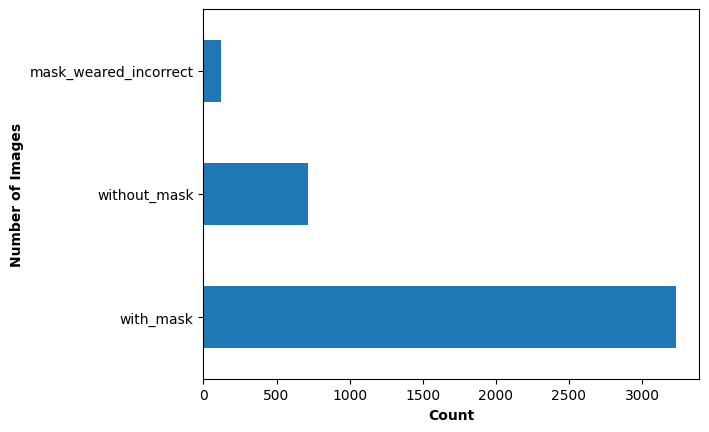

In [ ]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Number of Images', fontsize = 10, fontweight = 'bold')

In [ ]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '/content/drive/MyDrive/esproject'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        # print(path)
        if not os.path.exists(path):
            os.makedirs(path)

## Extracting Faces with mask/without mask/ incorrect mask

In [ ]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle 
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [ ]:
def extract_faces(image_name, image_info):
    
    '''
     This function takes an image name + dataframe with information about the image 
     and splits the image into all the different faces. image name contains the 
     upper-left coordinate of each face so we could distinguish it later
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        # faces.append(Image.open(image_path))
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [ ]:
cropped_faces = [extract_faces(img, df) for img in images]

In [ ]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

In [ ]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [ ]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

num of images with mask: 3231
num of images without mask: 715
num of images incorrect mask: 123
sum: 4069


In [ ]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [ ]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    # print(image)
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    # print(output_path)
    image.save(output_path)   

In [ ]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 100

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/esproject/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/esproject/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/esproject/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [ ]:
# plttrain_generator[0]

# MODEL


## Running for 100 epochs

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 100

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 128, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


model_custom.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 17, 17, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 4, 4, 64)       

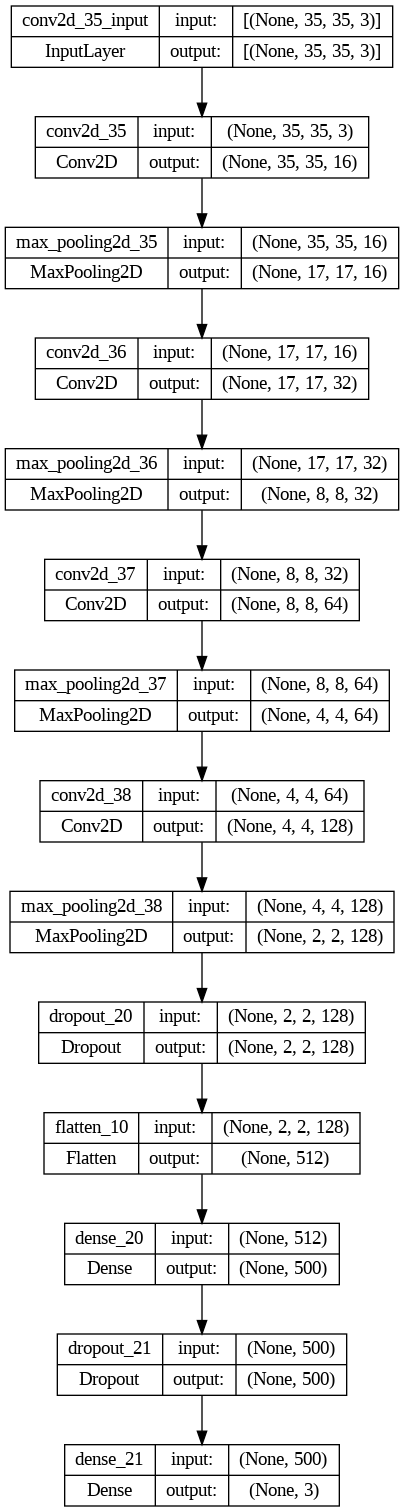

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model_custom, show_shapes=True, show_layer_names=True)

In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/100


<ipython-input-108-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 5s 63ms/step - loss: 0.6895 - accuracy: 0.7625 - recall: 0.7375 - precision: 0.7867 - auc: 0.8697 - val_loss: 0.6962 - val_accuracy: 0.7222 - val_recall: 0.7222 - val_precision: 0.7222 - val_auc: 0.8908 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 3s 56ms/step - loss: 0.5722 - accuracy: 0.8100 - recall: 0.8100 - precision: 0.8100 - auc: 0.9068 - val_loss: 0.6433 - val_accuracy: 0.7361 - val_recall: 0.7361 - val_precision: 0.7465 - val_auc: 0.9120 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 3s 65ms/step - loss: 0.5604 - accuracy: 0.7875 - recall: 0.7800 - precision: 0.7980 - auc: 0.9226 - val_loss: 0.3679 - val_accuracy: 0.7917 - val_recall: 0.7917 - val_precision: 0.8028 - val_auc: 0.9632 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 3s 57ms/step - loss: 0.3707 - accuracy: 0.8650 - recall: 0.8500 - precision: 0.8763 - auc: 0.9625 - val_loss: 0.2712 - val_accuracy: 0.9444 - val_recall

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 40ms/step - loss: 0.2112 - accuracy: 0.9136 - recall: 0.9053 - precision: 0.9244 - auc: 0.9894
Our Custom Model has a loss of 0.21 and accuracy 91.36%
Our Custom Model has a recall of 90.53%, precision of 92.44% and auc of 98.94%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 29ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

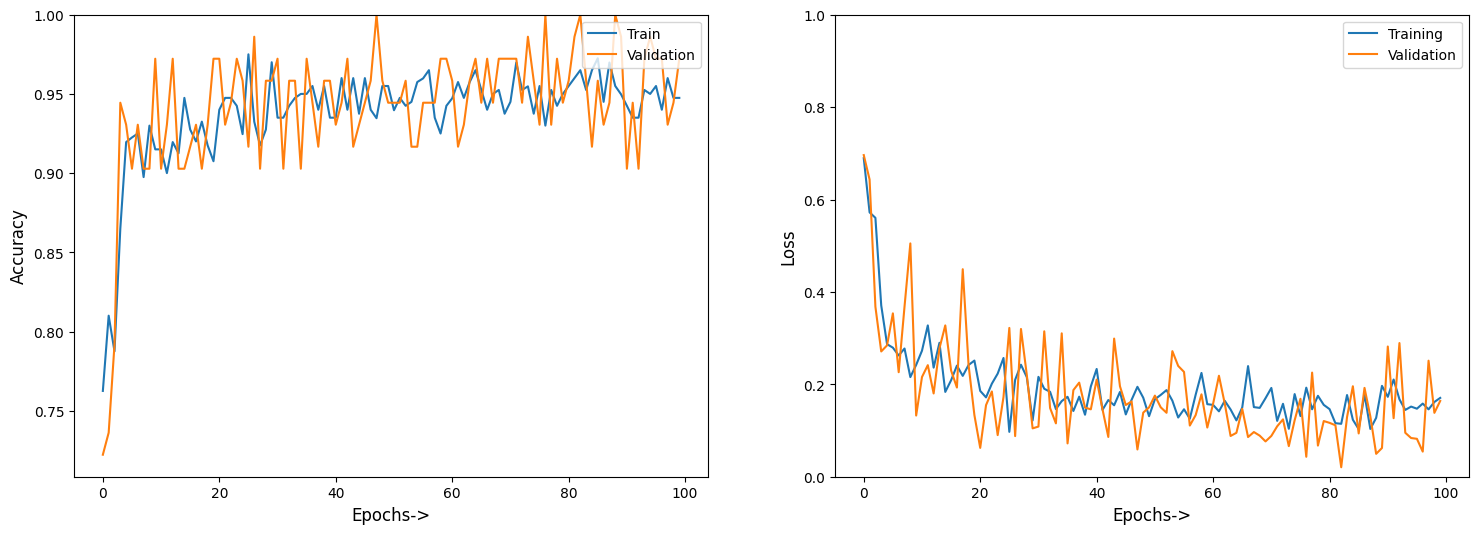

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

## Running Model for 10 epochs

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))



In [ ]:
from keras.utils.vis_utils import plot_model

# plot_model(model_custom, show_shapes=True, show_layer_names=True)

In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-42-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 5s 65ms/step - loss: 0.7080 - accuracy: 0.7775 - recall: 0.6625 - precision: 0.7982 - auc: 0.8702 - val_loss: 0.6307 - val_accuracy: 0.7917 - val_recall: 0.7917 - val_precision: 0.7917 - val_auc: 0.9000 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 5s 100ms/step - loss: 0.5883 - accuracy: 0.7875 - recall: 0.7825 - precision: 0.7884 - auc: 0.9096 - val_loss: 0.4693 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8310 - val_auc: 0.9504 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 4s 83ms/step - loss: 0.4214 - accuracy: 0.8125 - recall: 0.7975 - precision: 0.8201 - auc: 0.9564 - val_loss: 0.5488 - val_accuracy: 0.8750 - val_recall: 0.5694 - val_precision: 1.0000 - val_auc: 0.9712 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 4s 80ms/step - loss: 0.4138 - accuracy: 0.8575 - recall: 0.7900 - precision: 0.8802 - auc: 0.9553 - val_loss: 0.3061 - val_accuracy: 0.8889 - val_recall: 

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 32ms/step - loss: 0.2477 - accuracy: 0.9259 - recall: 0.9218 - precision: 0.9295 - auc: 0.9787
Our Custom Model has a loss of 0.25 and accuracy 92.59%
Our Custom Model has a recall of 92.18%, precision of 92.95% and auc of 97.87%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 37ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

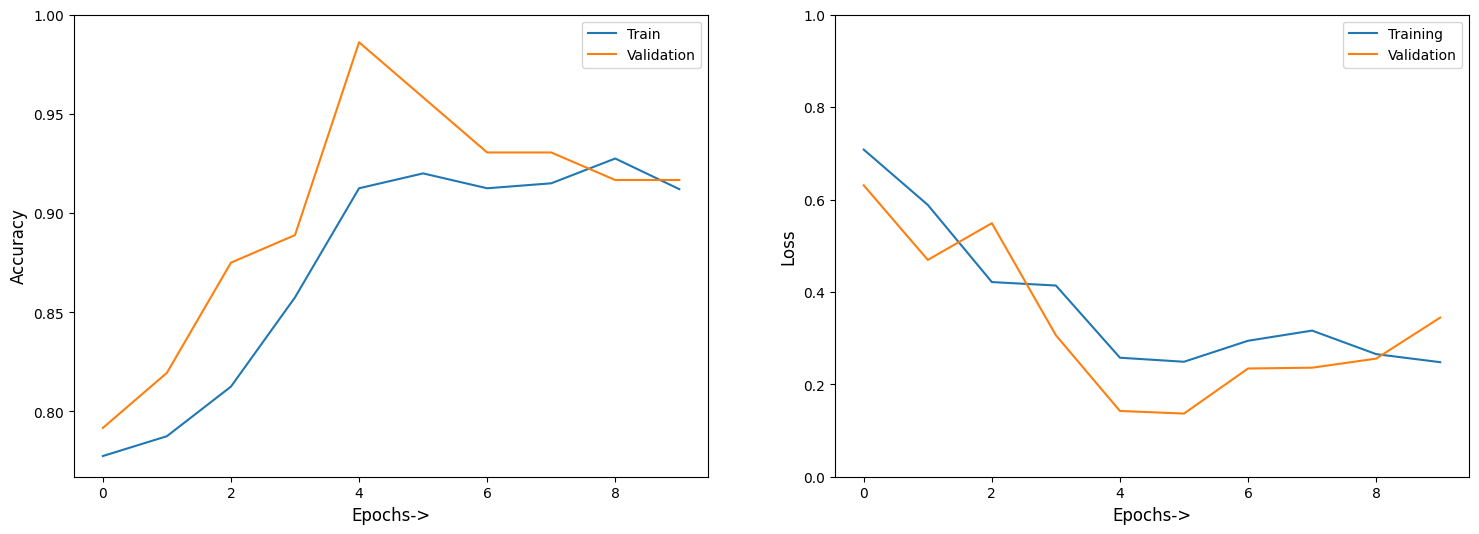

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

## Changing Model parameters

### Adjusting Number of Layers

#### Increasing number of layers

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(model_custom, show_shapes=True, show_layer_names=True)

In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-51-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 7s 65ms/step - loss: 0.6027 - accuracy: 0.8075 - recall: 0.7400 - precision: 0.8245 - auc: 0.9031 - val_loss: 0.7767 - val_accuracy: 0.7639 - val_recall: 0.7639 - val_precision: 0.7639 - val_auc: 0.8924 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 3s 56ms/step - loss: 0.5019 - accuracy: 0.7889 - recall: 0.7789 - precision: 0.8094 - auc: 0.9405 - val_loss: 0.3124 - val_accuracy: 0.8472 - val_recall: 0.8194 - val_precision: 0.9516 - val_auc: 0.9863 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 4s 69ms/step - loss: 0.4091 - accuracy: 0.8225 - recall: 0.7950 - precision: 0.8958 - auc: 0.9556 - val_loss: 0.5229 - val_accuracy: 0.7917 - val_recall: 0.7361 - val_precision: 0.8983 - val_auc: 0.9292 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 3s 56ms/step - loss: 0.3899 - accuracy: 0.8700 - recall: 0.8150 - precision: 0.9106 - auc: 0.9605 - val_loss: 0.4137 - val_accuracy: 0.9028 - val_recall: 0

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 31ms/step - loss: 0.2725 - accuracy: 0.9300 - recall: 0.9300 - precision: 0.9339 - auc: 0.9739
Our Custom Model has a loss of 0.27 and accuracy 93.00%
Our Custom Model has a recall of 93.00%, precision of 93.39% and auc of 97.39%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 29ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

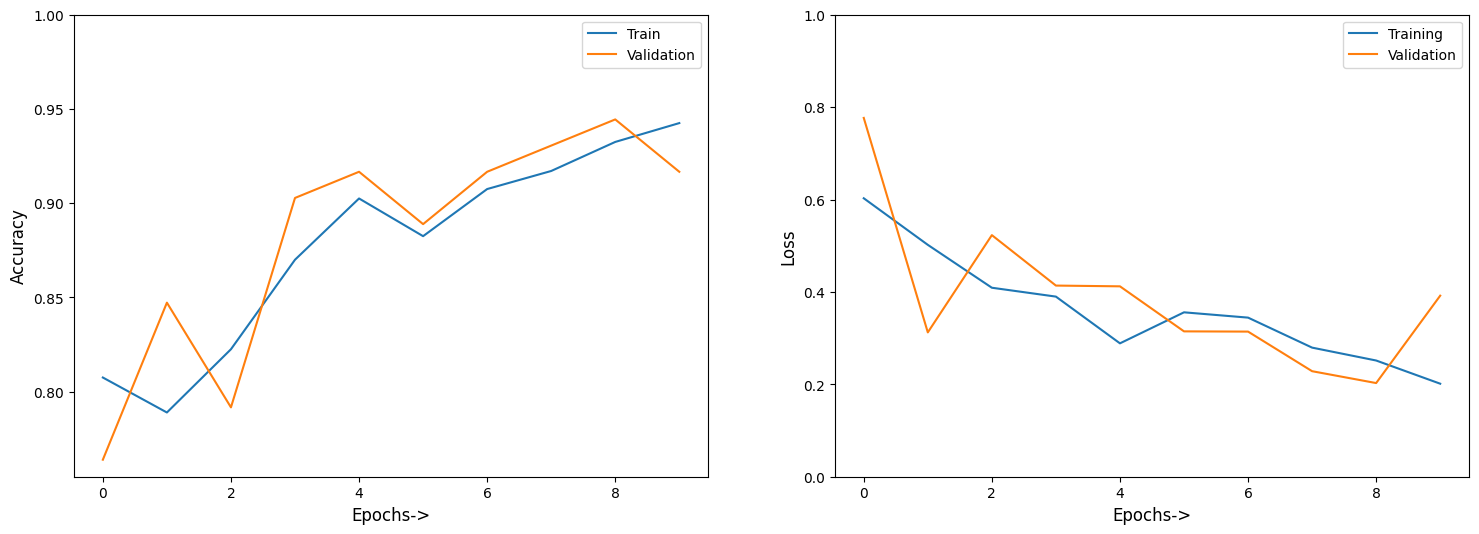

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

#### Decreasing Number of Layers

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))



In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-59-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 6s 68ms/step - loss: 0.5254 - accuracy: 0.8125 - recall: 0.7800 - precision: 0.8365 - auc: 0.9326 - val_loss: 0.6705 - val_accuracy: 0.8472 - val_recall: 0.7778 - val_precision: 0.8615 - val_auc: 0.9122 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 3s 56ms/step - loss: 0.3895 - accuracy: 0.8525 - recall: 0.8200 - precision: 0.8747 - auc: 0.9599 - val_loss: 0.3464 - val_accuracy: 0.9306 - val_recall: 0.8472 - val_precision: 0.9385 - val_auc: 0.9776 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 3s 58ms/step - loss: 0.2811 - accuracy: 0.9100 - recall: 0.8825 - precision: 0.9169 - auc: 0.9783 - val_loss: 0.5436 - val_accuracy: 0.8611 - val_recall: 0.8611 - val_precision: 0.8611 - val_auc: 0.9656 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 4s 76ms/step - loss: 0.2968 - accuracy: 0.8970 - recall: 0.8819 - precision: 0.9093 - auc: 0.9740 - val_loss: 0.3782 - val_accuracy: 0.9028 - val_recall: 0

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 36ms/step - loss: 0.2610 - accuracy: 0.9177 - recall: 0.9136 - precision: 0.9328 - auc: 0.9803
Our Custom Model has a loss of 0.26 and accuracy 91.77%
Our Custom Model has a recall of 91.36%, precision of 93.28% and auc of 98.03%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 33ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

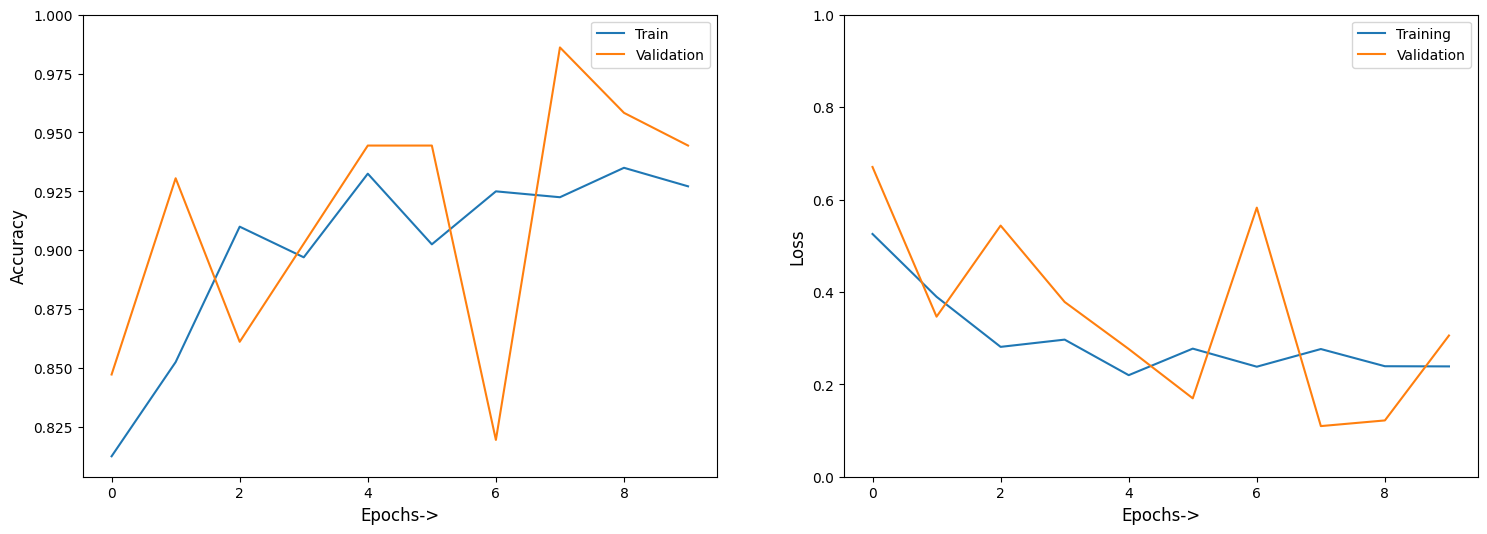

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

### Adjusting Size of layers

#### Decreasing size of layers

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-67-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 5s 57ms/step - loss: 0.6315 - accuracy: 0.7915 - recall: 0.7663 - precision: 0.8005 - auc: 0.8917 - val_loss: 0.6218 - val_accuracy: 0.7639 - val_recall: 0.7639 - val_precision: 0.7639 - val_auc: 0.9046 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 3s 50ms/step - loss: 0.6002 - accuracy: 0.7725 - recall: 0.7675 - precision: 0.7733 - auc: 0.9012 - val_loss: 0.3627 - val_accuracy: 0.8472 - val_recall: 0.8333 - val_precision: 0.8451 - val_auc: 0.9676 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 3s 52ms/step - loss: 0.4754 - accuracy: 0.8065 - recall: 0.7814 - precision: 0.8338 - auc: 0.9403 - val_loss: 0.3844 - val_accuracy: 0.8472 - val_recall: 0.8472 - val_precision: 0.8714 - val_auc: 0.9577 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 3s 61ms/step - loss: 0.3465 - accuracy: 0.8850 - recall: 0.8575 - precision: 0.9003 - auc: 0.9666 - val_loss: 0.3197 - val_accuracy: 0.9167 - val_recall: 0

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 28ms/step - loss: 0.2455 - accuracy: 0.9259 - recall: 0.9259 - precision: 0.9336 - auc: 0.9821
Our Custom Model has a loss of 0.25 and accuracy 92.59%
Our Custom Model has a recall of 92.59%, precision of 93.36% and auc of 98.21%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 30ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

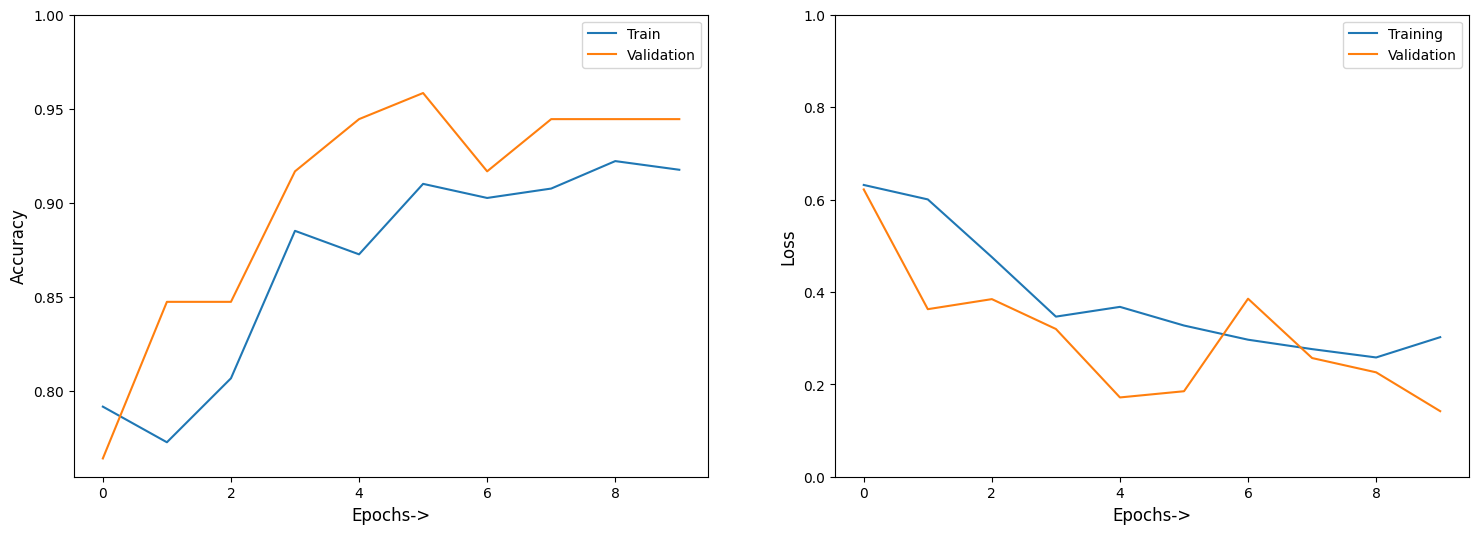

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

#### Increasing size of layers

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-75-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 7s 93ms/step - loss: 0.5995 - accuracy: 0.7925 - recall: 0.7775 - precision: 0.8057 - auc: 0.9068 - val_loss: 0.4465 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8194 - val_auc: 0.9521 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 6s 112ms/step - loss: 0.4808 - accuracy: 0.8518 - recall: 0.8291 - precision: 0.8730 - auc: 0.9431 - val_loss: 0.2681 - val_accuracy: 0.8472 - val_recall: 0.8333 - val_precision: 0.8451 - val_auc: 0.9849 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 4s 79ms/step - loss: 0.3916 - accuracy: 0.8575 - recall: 0.8375 - precision: 0.8747 - auc: 0.9596 - val_loss: 0.2112 - val_accuracy: 0.9722 - val_recall: 0.9444 - val_precision: 0.9714 - val_auc: 0.9927 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 6s 109ms/step - loss: 0.2933 - accuracy: 0.9000 - recall: 0.8850 - precision: 0.9031 - auc: 0.9763 - val_loss: 0.2607 - val_accuracy: 0.9583 - val_recall:

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 33ms/step - loss: 0.2612 - accuracy: 0.9259 - recall: 0.9218 - precision: 0.9256 - auc: 0.9766
Our Custom Model has a loss of 0.26 and accuracy 92.59%
Our Custom Model has a recall of 92.18%, precision of 92.56% and auc of 97.66%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 32ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

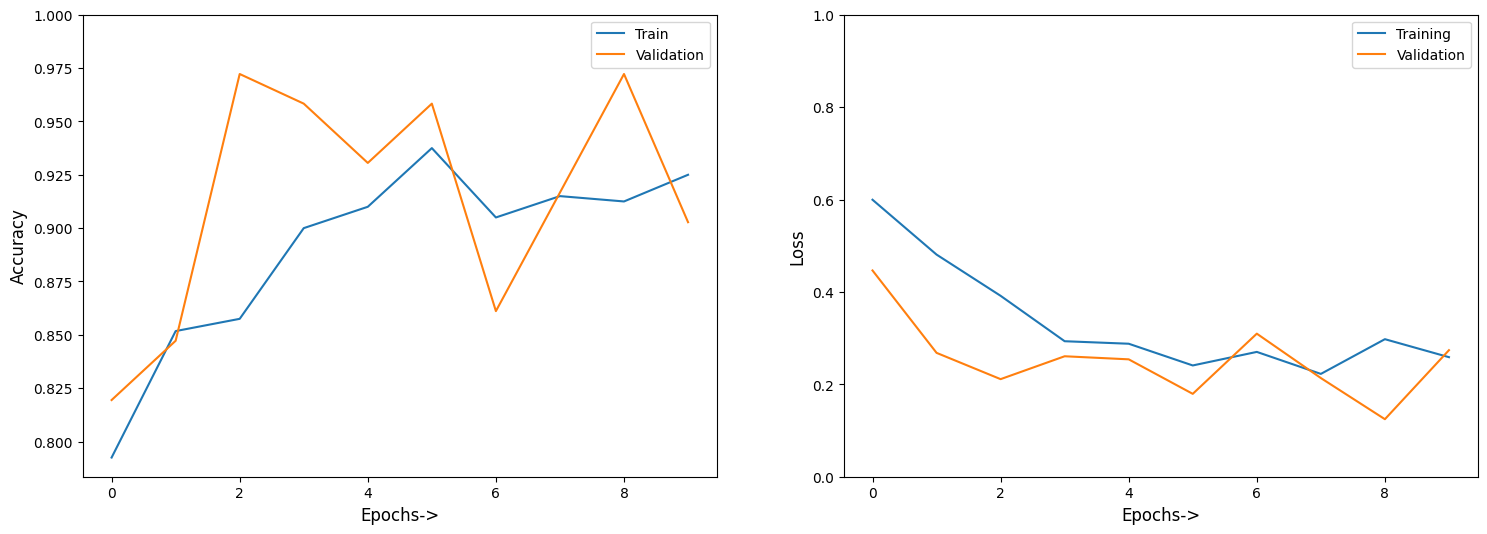

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

### Changing Activation function of layers

#### Using Sigmoid function:

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'sigmoid', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'sigmoid'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'sigmoid'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'sigmoid'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-83-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 7s 100ms/step - loss: 0.7636 - accuracy: 0.7675 - recall: 0.7425 - precision: 0.7615 - auc: 0.8740 - val_loss: 0.5532 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8194 - val_auc: 0.8958 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 3s 56ms/step - loss: 0.6618 - accuracy: 0.7750 - recall: 0.7700 - precision: 0.7797 - auc: 0.8734 - val_loss: 0.4654 - val_accuracy: 0.8472 - val_recall: 0.8472 - val_precision: 0.8472 - val_auc: 0.9236 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 3s 54ms/step - loss: 0.6888 - accuracy: 0.7550 - recall: 0.7550 - precision: 0.7550 - auc: 0.8711 - val_loss: 0.7207 - val_accuracy: 0.7639 - val_recall: 0.7639 - val_precision: 0.7639 - val_auc: 0.8824 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 3s 63ms/step - loss: 0.6830 - accuracy: 0.7900 - recall: 0.7800 - precision: 0.7939 - auc: 0.8730 - val_loss: 0.7315 - val_accuracy: 0.7500 - val_recall: 

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 28ms/step - loss: 0.6292 - accuracy: 0.7984 - recall: 0.7984 - precision: 0.7984 - auc: 0.8855
Our Custom Model has a loss of 0.63 and accuracy 79.84%
Our Custom Model has a recall of 79.84%, precision of 79.84% and auc of 88.55%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 27ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

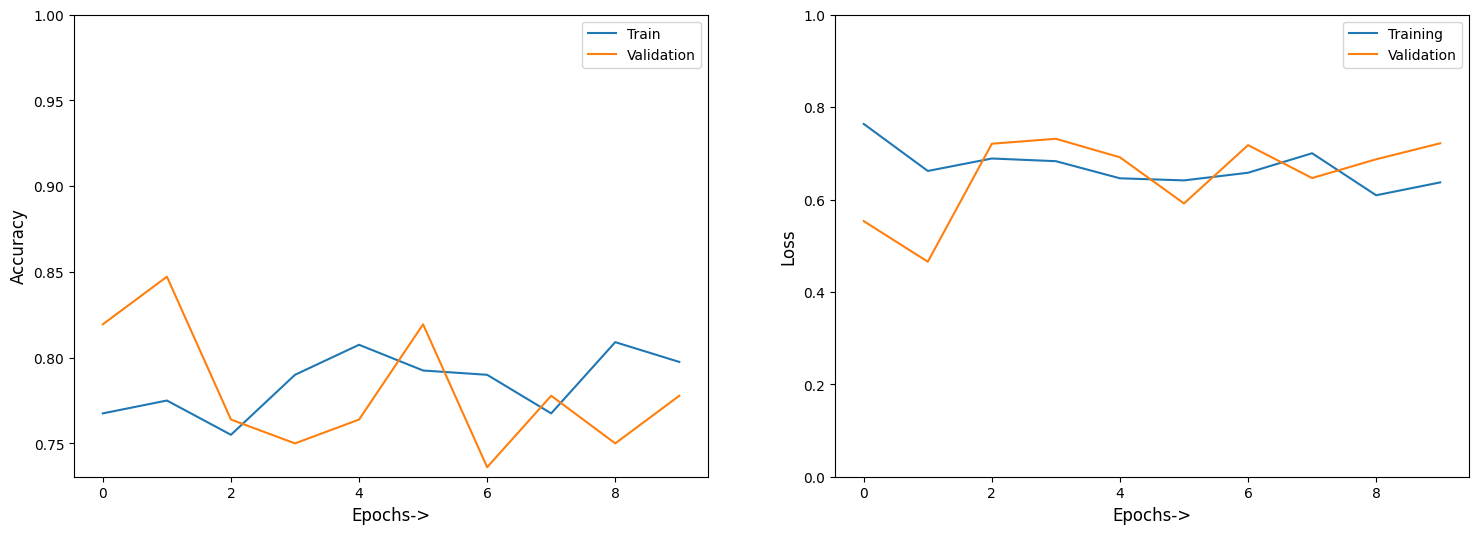

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

#### Using ReLu Function

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-91-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 6s 65ms/step - loss: 0.6271 - accuracy: 0.7450 - recall: 0.7150 - precision: 0.7814 - auc: 0.9002 - val_loss: 0.4520 - val_accuracy: 0.7500 - val_recall: 0.7500 - val_precision: 0.7826 - val_auc: 0.9577 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 3s 51ms/step - loss: 0.5021 - accuracy: 0.8025 - recall: 0.7575 - precision: 0.8393 - auc: 0.9319 - val_loss: 0.2741 - val_accuracy: 0.8472 - val_recall: 0.8194 - val_precision: 0.8676 - val_auc: 0.9808 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 3s 50ms/step - loss: 0.3470 - accuracy: 0.8700 - recall: 0.8600 - precision: 0.8821 - auc: 0.9669 - val_loss: 0.3863 - val_accuracy: 0.9028 - val_recall: 0.8472 - val_precision: 0.9104 - val_auc: 0.9602 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 4s 82ms/step - loss: 0.3106 - accuracy: 0.9075 - recall: 0.8800 - precision: 0.9119 - auc: 0.9720 - val_loss: 0.2571 - val_accuracy: 0.9306 - val_recall: 0

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 32ms/step - loss: 0.2982 - accuracy: 0.9383 - recall: 0.9383 - precision: 0.9383 - auc: 0.9728
Our Custom Model has a loss of 0.30 and accuracy 93.83%
Our Custom Model has a recall of 93.83%, precision of 93.83% and auc of 97.28%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 28ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

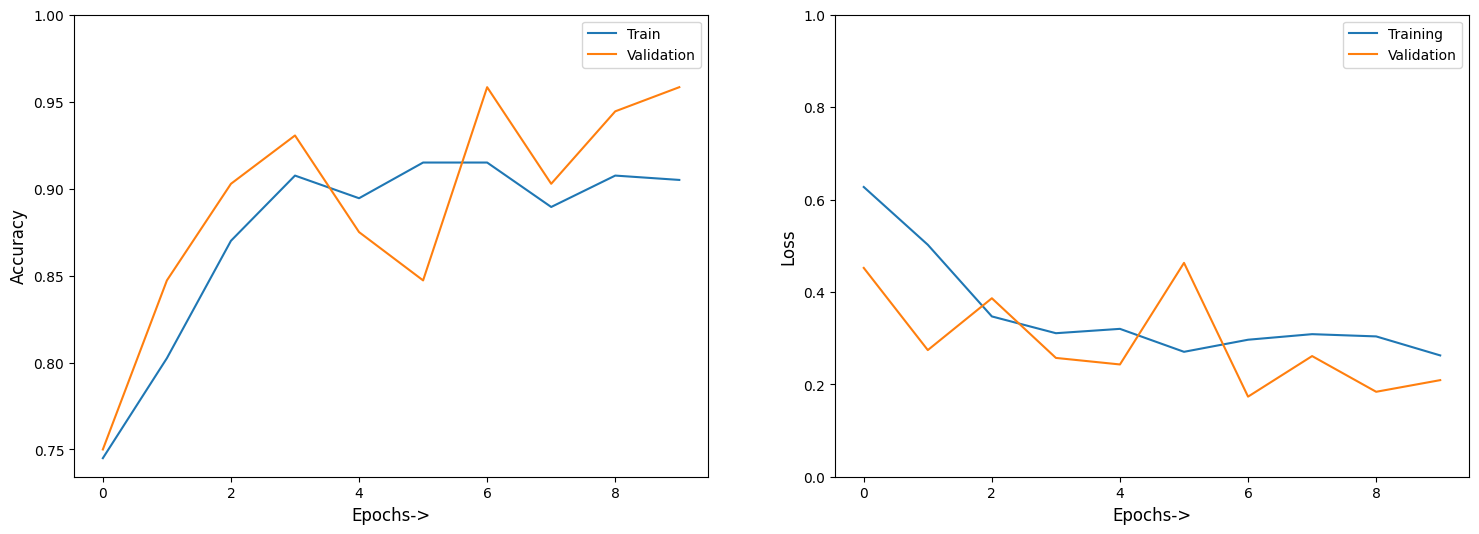

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)

#### Using ELu Function

In [ ]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'elu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'elu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'elu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [ ]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/10


<ipython-input-99-cfeccaaad30f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 7s 99ms/step - loss: 0.5685 - accuracy: 0.8300 - recall: 0.7925 - precision: 0.8431 - auc: 0.9158 - val_loss: 0.3257 - val_accuracy: 0.8750 - val_recall: 0.8472 - val_precision: 0.9104 - val_auc: 0.9679 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 3s 63ms/step - loss: 0.3732 - accuracy: 0.8875 - recall: 0.8475 - precision: 0.9016 - auc: 0.9635 - val_loss: 0.2969 - val_accuracy: 0.9444 - val_recall: 0.9444 - val_precision: 0.9444 - val_auc: 0.9621 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 3s 56ms/step - loss: 0.2290 - accuracy: 0.9325 - recall: 0.9250 - precision: 0.9415 - auc: 0.9843 - val_loss: 0.6654 - val_accuracy: 0.9028 - val_recall: 0.9028 - val_precision: 0.9028 - val_auc: 0.9385 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 4s 87ms/step - loss: 0.2923 - accuracy: 0.9150 - recall: 0.9050 - precision: 0.9165 - auc: 0.9766 - val_loss: 0.1842 - val_accuracy: 0.9583 - val_recall: 0

In [ ]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 1s 36ms/step - loss: 0.4592 - accuracy: 0.9012 - recall: 0.8971 - precision: 0.9046 - auc: 0.9650
Our Custom Model has a loss of 0.46 and accuracy 90.12%
Our Custom Model has a recall of 89.71%, precision of 90.46% and auc of 96.50%


In [ ]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 1s 37ms/step
predictions shape: (243, 3)


Text(0.5, 0, 'Epochs->')

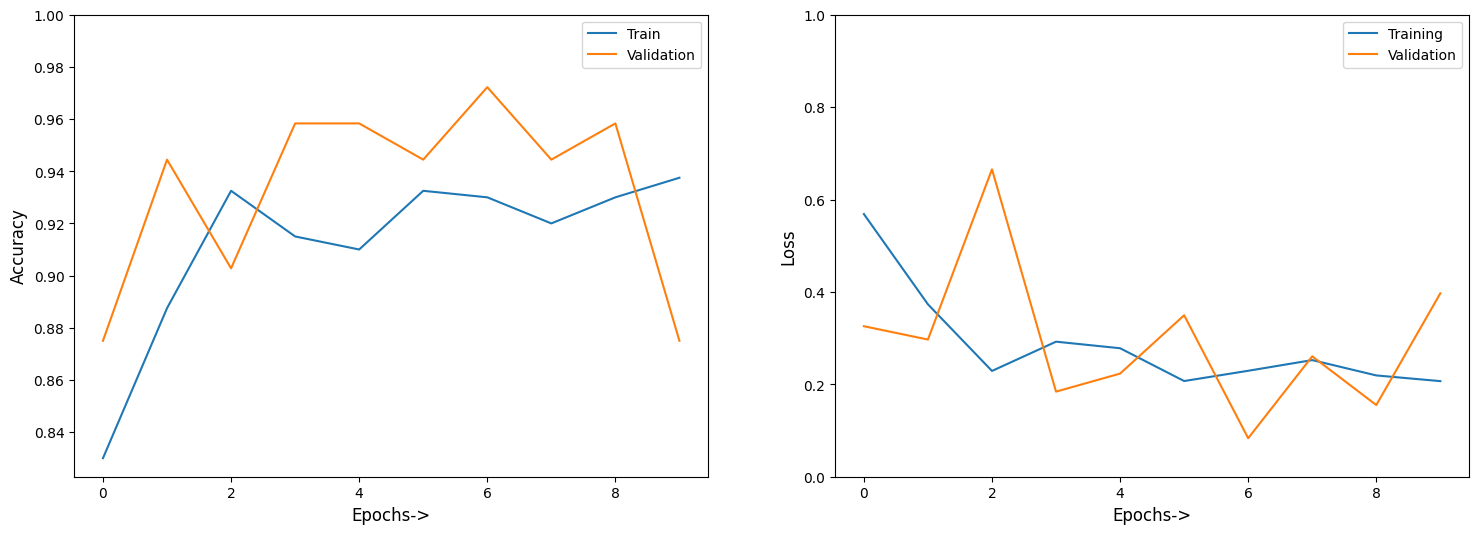

In [ ]:

acc = model_custom_history.history['accuracy']
val_acc = model_custom_history.history['val_accuracy']
loss = model_custom_history.history['loss']
val_loss = model_custom_history.history['val_loss']

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])

plt.xlabel('Epochs->', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.xlabel('Epochs->', fontsize=12)